# Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects of the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [335]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [336]:
asl.df.shape

(15746, 7)

In [337]:
asl.df.loc[98,1]  # look at the data available for an individual frame

left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [338]:
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']
asl.df.head() # the new feature 'grnd-lx' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-lx  
video frame           
98    0          -12  
      1          -12  
      2          -12  
      3          -12  
      4          -12

##### Try it!

In [339]:
from asl_utils import test_features_tryit
# TODO add df columns for 'grnd-ly', 'grnd-rx', 'grnd-ry' representing differences between hand and nose locations
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-lx  grnd-ly  grnd-rx  grnd-ry  
video frame                                      
98    0          -12      119        9      113  
      1          -12      119        9      113  
      2          -12      119        9      113  
      3          -12      119        9      113  
      4          -12      119        9      113

In [340]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
# show a single set of features for a given (video, frame) tuple
[asl.df.loc[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [341]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['TOY1', 'NOT', 'HOMEWORK', 'BUT', 'FRIEND', 'GIVE1', 'BOX', 'WOMAN', 'PUTASIDE', 'DECIDE', 'WANT', 'CHINA', 'NEW', 'PAST', 'BROCCOLI', 'CANDY', 'VEGETABLE', 'SOMETHING-ONE', 'CORN', 'WILL', 'WHAT', 'THINK', 'IX-1P', 'SEE', 'FUTURE', 'LAST-WEEK', 'JANA', 'WONT', 'MOTHER', 'CORN1', 'SEARCH-FOR', 'MOVIE', 'EAT', 'WRITE', 'GO1', 'THROW', 'SHOOT', 'TOY', 'FINISH', 'GROUP', 'FIND', 'VISIT', 'BOOK', 'PARTY', 'CHOCOLATE', 'VIDEOTAPE', 'ALL', 'CAR', 'READ', 'FUTURE1', 'POSS', 'MAN', 'BLAME', 'JOHN', 'BUY1', 'FRED', 'IX', 'HOUSE', 'SAY-1P', 'BUY', 'CAN', 'TEACHER', 'LIKE', 'LEG', 'MANY', 'BORROW', 'YESTERDAY', 'KNOW', 'POTATO', 'FRANK', 'GIRL', 'NEW-YORK', 'LOVE', 'BLUE', 'BOY', 'GO2', 'LIVE', 'GIVE', 'BREAK-DOWN', 'STUDENT', 'TOMORROW', 'HIT', 'SUE', 'TELL', 'SHOULD', 'BILL', 'GIVE3', 'LEAVE', 'FISH', 'PEOPLE', 'APPLE', 'PREFER', 'NEXT-WEEK', 'HAVE', 'NAME', 'GIVE2', 'SELL', 'GET', 'CHICKEN', 'OLD', 'ANN', 'WHO', 'MARY', 'CHICAGO', 'COAT', 'ARRIVE', 'BROTHER', 'SELF', 'HERE', '

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  In addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences (the X portion) and the second is a list of the sequence lengths (the Lengths portion).

In [342]:
training.get_word_Xlengths('ALL')

(array([[-64,  36,  31, 180],
        [-64,  36,  31, 180],
        [-64,  36,  31, 180],
        [-64,  36,  31, 180],
        [-71,  39,  31, 180],
        [-71,  39,  31, 180],
        [-76,  43,  31, 180],
        [-76,  43,  31, 180],
        [-60,  39,  35, 181],
        [-60,  39,  34, 177],
        [-54,  26,  32, 177],
        [-47,  23,  27, 169],
        [-62,  35,  22, 181],
        [-81,  29,  19, 182],
        [-92,  27,  17, 181],
        [-97,  28,  17, 181],
        [-97,  28,  17, 181],
        [-86,  21,  17, 181],
        [-68,  22,  21, 184],
        [-49,  18,  24, 183],
        [-38,  15,  25, 181],
        [-31,   9,  25, 181],
        [-28,   8,  28, 180]]), [12, 11])

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [343]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-lx,grnd-ly,grnd-rx,grnd-ry
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,31.216447,157.036848,-19.567406,88.728430
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,2.006318,104.026144,-11.637255,60.087364
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,12.895536,118.505134,-13.452679,61.813616


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [345]:
df_tmp = pd.DataFrame()
df_tmp['left-x-mean'] = asl.df['speaker'].map(df_means['left-x'])
df_tmp.head()

left-x-mean
video frame             
98    0       164.661438
      1       164.661438
      2       164.661438
      3       164.661438
      4       164.661438

##### Try it!

In [346]:
from asl_utils import test_std_tryit
# Add the rest of the means
df_tmp['left-y-mean'] = asl.df['speaker'].map(df_means['left-y'])
df_tmp['right-x-mean'] = asl.df['speaker'].map(df_means['right-x'])
df_tmp['right-y-mean'] = asl.df['speaker'].map(df_means['right-y'])

# TODO Create a dataframe named `df_std` with standard deviations grouped by speaker
df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-lx,grnd-ly,grnd-rx,grnd-ry
speaker,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,15.080360,36.572749,20.269032,53.487999
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,17.328941,27.117393,16.764706,33.972660
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,15.050938,29.320655,16.191324,39.128572


In [347]:
df_tmp['left-x-std'] = asl.df['speaker'].map(df_std['left-x'])
df_tmp['left-y-std'] = asl.df['speaker'].map(df_std['left-y'])
df_tmp['right-x-std'] = asl.df['speaker'].map(df_std['right-x'])
df_tmp['right-y-std'] = asl.df['speaker'].map(df_std['right-y'])
df_tmp.head()

left-x-mean  left-y-mean  right-x-mean  right-y-mean  left-x-std  \
video frame                                                                     
98    0       164.661438   161.271242    151.017865    117.332462   17.573442   
      1       164.661438   161.271242    151.017865    117.332462   17.573442   
      2       164.661438   161.271242    151.017865    117.332462   17.573442   
      3       164.661438   161.271242    151.017865    117.332462   17.573442   
      4       164.661438   161.271242    151.017865    117.332462   17.573442   

             left-y-std  right-x-std  right-y-std  
video frame                                        
98    0       26.594521    16.459943    34.667787  
      1       26.594521    16.459943    34.667787  
      2       26.594521    16.459943    34.667787  
      3       26.594521    16.459943    34.667787  
      4       26.594521    16.459943    34.667787

<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [348]:
# TODO add features for normalized-by-speaker values of left, right, x, y
# Name these 'norm-rx', 'norm-ry', 'norm-lx', and 'norm-ly'
# using Z-score scaling (X-Xmean)/Xstd

asl.df['norm-lx'] = (asl.df['left-x'] - df_tmp['left-x-mean']) / df_tmp['left-x-std']
asl.df['norm-ly'] = (asl.df['left-y'] - df_tmp['left-y-mean']) / df_tmp['left-y-std']
asl.df['norm-rx'] = (asl.df['right-x'] - df_tmp['right-x-mean']) / df_tmp['right-x-std']
asl.df['norm-ry'] = (asl.df['right-y'] - df_tmp['right-y-mean']) / df_tmp['right-y-std']

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [349]:
# TODO add features for polar coordinate values where the nose is the origin
# Name these 'polar-rr', 'polar-rtheta', 'polar-lr', and 'polar-ltheta'
# Note that 'polar-rr' and 'polar-rtheta' refer to the radius and angle

asl.df['polar-lr'] = np.sqrt(asl.df['grnd-lx']**2 + asl.df['grnd-ly']**2)
asl.df['polar-ltheta'] = np.arctan2(asl.df['grnd-lx'], asl.df['grnd-ly'])
asl.df['polar-rr'] = np.sqrt(asl.df['grnd-rx']**2 + asl.df['grnd-ry']**2)
asl.df['polar-rtheta'] = np.arctan2(asl.df['grnd-rx'], asl.df['grnd-ry'])

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [350]:
# TODO add features for left, right, x, y differences by one time step, i.e. the "delta" values discussed in the lecture
# Name these 'delta-rx', 'delta-ry', 'delta-lx', and 'delta-ly'

asl.df['delta-lx'] = asl.df['left-x'].diff().fillna(0)
asl.df['delta-ly'] = asl.df['left-y'].diff().fillna(0)
asl.df['delta-rx'] = asl.df['right-x'].diff().fillna(0)
asl.df['delta-ry'] = asl.df['right-y'].diff().fillna(0)

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [351]:
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-lx  grnd-ly  grnd-rx    ...      norm-rx   norm-ry  \
video frame                               ...                          
98    0          -12      119        9    ...     1.153232  1.663433   
      1          -12      119        9    ...     1.153232  1.663433   
      2          -12      119        9    ...     1.153232  1.663433   
      3          -12      119        9    ...     1.153232  1.663433   
      4          -12      119        9    ...     1.153232  1.663433   

               polar-lr  polar-ltheta   polar-rr  polar-rtheta  delta-lx  \
video frame                                                                
98    0      119.603512     -0.100501  113.35784      0.079478       0.0   
      1      119.603512     -0.100501  113.35784      0.079478       0.0   
      2      119.603512     -0.100501  113.35784      0.079478       0.0   
      3      119.603512     -0.100501  113.35784      0.079478       0.0   
      4      119.603512     -0.100501  113.35784      0.079478       0.0   

             delta-ly  delta-rx  delta-ry  
video frame                                
98    0           0.0       0.0       0.0  
      1           0.0       0.0       0.0  
      2           0.0       0.0       0.0  
      3           0.0       0.0       0.0  
      4           0.0       0.0       0.0  

[5 rows x 23 columns]

In [352]:
df_tmp.head()

left-x-mean  left-y-mean  right-x-mean  right-y-mean  left-x-std  \
video frame                                                                     
98    0       164.661438   161.271242    151.017865    117.332462   17.573442   
      1       164.661438   161.271242    151.017865    117.332462   17.573442   
      2       164.661438   161.271242    151.017865    117.332462   17.573442   
      3       164.661438   161.271242    151.017865    117.332462   17.573442   
      4       164.661438   161.271242    151.017865    117.332462   17.573442   

             left-y-std  right-x-std  right-y-std  
video frame                                        
98    0       26.594521    16.459943    34.667787  
      1       26.594521    16.459943    34.667787  
      2       26.594521    16.459943    34.667787  
      3       26.594521    16.459943    34.667787  
      4       26.594521    16.459943    34.667787

In [394]:
df_means = asl.df.groupby('speaker').mean()
df_std = asl.df.groupby('speaker').std()

# Calculate ground coordinate means
df_tmp['grnd-lx-mean'] = asl.df['speaker'].map(df_means['grnd-lx'])
df_tmp['grnd-ly-mean'] = asl.df['speaker'].map(df_means['grnd-ly'])
df_tmp['grnd-rx-mean'] = asl.df['speaker'].map(df_means['grnd-rx'])
df_tmp['grnd-ry-mean'] = asl.df['speaker'].map(df_means['grnd-ry'])

# Calculate ground coordinate standard deviations
df_tmp['grnd-lx-std'] = asl.df['speaker'].map(df_std['grnd-lx'])
df_tmp['grnd-ly-std'] = asl.df['speaker'].map(df_std['grnd-ly'])
df_tmp['grnd-rx-std'] = asl.df['speaker'].map(df_std['grnd-rx'])
df_tmp['grnd-ry-std'] = asl.df['speaker'].map(df_std['grnd-ry'])

# Calculate polar coordinate means
df_tmp['polar-lr-mean'] = asl.df['speaker'].map(df_means['polar-lr'])
df_tmp['polar-ltheta-mean'] = asl.df['speaker'].map(df_means['polar-ltheta'])
df_tmp['polar-rr-mean'] = asl.df['speaker'].map(df_means['polar-rr'])
df_tmp['polar-rtheta-mean'] = asl.df['speaker'].map(df_means['polar-rtheta'])

# Calculate polar coordinate standard deviations
df_tmp['polar-lr-std'] = asl.df['speaker'].map(df_std['polar-lr'])
df_tmp['polar-ltheta-std'] = asl.df['speaker'].map(df_std['polar-ltheta'])
df_tmp['polar-rr-std'] = asl.df['speaker'].map(df_std['polar-rr'])
df_tmp['polar-rtheta-std'] = asl.df['speaker'].map(df_std['polar-rtheta'])

df_tmp.head()

left-x-mean  left-y-mean  right-x-mean  right-y-mean  left-x-std  \
video frame                                                                     
98    0       164.661438   161.271242    151.017865    117.332462   17.573442   
      1       164.661438   161.271242    151.017865    117.332462   17.573442   
      2       164.661438   161.271242    151.017865    117.332462   17.573442   
      3       164.661438   161.271242    151.017865    117.332462   17.573442   
      4       164.661438   161.271242    151.017865    117.332462   17.573442   

             left-y-std  right-x-std  right-y-std  grnd-lx-mean  grnd-ly-mean  \
video frame                                                                     
98    0       26.594521    16.459943    34.667787      2.006318    104.026144   
      1       26.594521    16.459943    34.667787      2.006318    104.026144   
      2       26.594521    16.459943    34.667787      2.006318    104.026144   
      3       26.594521    16.459943    34.667787      2.006318    104.026144   
      4       26.594521    16.459943    34.667787      2.006318    104.026144   

                   ...         grnd-rx-std  grnd-ry-std  polar-lr-mean  \
video frame        ...                                                   
98    0            ...           16.764706     33.97266     105.968447   
      1            ...           16.764706     33.97266     105.968447   
      2            ...           16.764706     33.97266     105.968447   
      3            ...           16.764706     33.97266     105.968447   
      4            ...           16.764706     33.97266     105.968447   

             polar-ltheta-mean  polar-rr-mean  polar-rtheta-mean  \
video frame                                                        
98    0               0.060601      65.125528          -0.302214   
      1               0.060601      65.125528          -0.302214   
      2               0.060601      65.125528          -0.302214   
      3               0.060601      65.125528          -0.302214   
      4               0.060601      65.125528          -0.302214   

             polar-lr-std  polar-ltheta-std  polar-rr-std  polar-rtheta-std  
video frame                                                                  
98    0         25.133829          0.219121     30.654063          0.397837  
      1         25.133829          0.219121     30.654063          0.397837  
      2         25.133829          0.219121     30.654063          0.397837  
      3         25.133829          0.219121     30.654063          0.397837  
      4         25.133829          0.219121     30.654063          0.397837  

[5 rows x 24 columns]

In [413]:
# TODO add features of your own design, which may be a combination of the above or something else
# Name these whatever you would like

# Normalized ground coordinates
asl.df['grnd-lx-norm'] = (asl.df['grnd-lx'] - df_tmp['grnd-lx-mean']) / df_tmp['grnd-lx-std']
asl.df['grnd-ly-norm'] = (asl.df['grnd-ly'] - df_tmp['grnd-ly-mean']) / df_tmp['grnd-ly-std']
asl.df['grnd-rx-norm'] = (asl.df['grnd-rx'] - df_tmp['grnd-rx-mean']) / df_tmp['grnd-rx-std']
asl.df['grnd-ry-norm'] = (asl.df['grnd-ry'] - df_tmp['grnd-ry-mean']) / df_tmp['grnd-ry-std']

# Normalized polar coordinates
asl.df['polar-lr-norm'] = (asl.df['polar-lr'] - df_tmp['polar-lr-mean']) / df_tmp['polar-lr-std']
asl.df['polar-ltheta-norm'] = (asl.df['polar-ltheta'] - df_tmp['polar-ltheta-mean']) / df_tmp['polar-ltheta-std']
asl.df['polar-rr-norm'] = (asl.df['polar-rr'] - df_tmp['polar-rr-mean']) / df_tmp['polar-rr-std']
asl.df['polar-rtheta-norm'] = (asl.df['polar-rtheta'] - df_tmp['polar-rtheta-mean']) / df_tmp['polar-rtheta-std']

# Moving averages across the current cell and the last 5 - 1 = 4 rows per column
asl.df['grnd-lx-mov'] = asl.df['grnd-lx'].rolling(window=5, min_periods=1).mean()
asl.df['grnd-ly-mov'] = asl.df['grnd-ly'].rolling(window=5, min_periods=1).mean()
asl.df['grnd-rx-mov'] = asl.df['grnd-rx'].rolling(window=5, min_periods=1).mean()
asl.df['grnd-ry-mov'] = asl.df['grnd-ry'].rolling(window=5, min_periods=1).mean()

# TODO define a list named 'features_custom' for building the training set
features_custom = [
    'grnd-lx-norm',
    'grnd-ly-norm',
    'grnd-rx-norm',
    'grnd-ry-norm',
    'polar-lr-norm',
    'polar-ltheta-norm',
    'polar-rr-norm',
    'polar-rtheta-norm',
    'grnd-lx-mov',
    'grnd-ly-mov',
    'grnd-rx-mov',
    'grnd-ry-mov',
]

asl.df.head(10)

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   
      5         149     181      170      175     161      62  woman-1   
      6         149     181      170      175     161      62  woman-1   
      7         149     181      170      175     161      62  woman-1   
      8         149     181      170      175     161      62  woman-1   
      9         149     181      170      175     161      62  woman-1   

             grnd-lx  grnd-ly  grnd-rx     ...       grnd-rx-norm  \
video frame                                ...                      
98    0          -12      119        9     ...           1.230994   
      1          -12      119        9     ...           1.230994   
      2          -12      119        9     ...           1.230994   
      3          -12      119        9     ...           1.230994   
      4          -12      119        9     ...           1.230994   
      5          -12      119        9     ...           1.230994   
      6          -12      119        9     ...           1.230994   
      7          -12      119        9     ...           1.230994   
      8          -12      119        9     ...           1.230994   
      9          -12      119        9     ...           1.230994   

             grnd-ry-norm  polar-lr-norm  polar-ltheta-norm  polar-rr-norm  \
video frame                                                                  
98    0          1.557506       0.542499          -0.735219       1.573439   
      1          1.557506       0.542499          -0.735219       1.573439   
      2          1.557506       0.542499          -0.735219       1.573439   
      3          1.557506       0.542499          -0.735219       1.573439   
      4          1.557506       0.542499          -0.735219       1.573439   
      5          1.557506       0.542499          -0.735219       1.573439   
      6          1.557506       0.542499          -0.735219       1.573439   
      7          1.557506       0.542499          -0.735219       1.573439   
      8          1.557506       0.542499          -0.735219       1.573439   
      9          1.557506       0.542499          -0.735219       1.573439   

             polar-rtheta-norm  grnd-lx-mov  grnd-ly-mov  grnd-rx-mov  \
video frame                                                             
98    0               0.959419        -12.0        119.0          9.0   
      1               0.959419        -12.0        119.0          9.0   
      2               0.959419        -12.0        119.0          9.0   
      3               0.959419        -12.0        119.0          9.0   
      4               0.959419        -12.0        119.0          9.0   
      5               0.959419        -12.0        119.0          9.0   
      6               0.959419        -12.0        119.0          9.0   
      7               0.959419        -12.0        119.0          9.0   
      8               0.959419        -12.0        119.0          9.0   
      9               0.959419        -12.0        119.0          9.0   

             grnd-ry-mov  
video frame               
98    0            113.0  
      1            113.0  
      2            113.0  
      3            113.0  
      4            113.0  
      5            113.0  
      6            113.0  
      7            113.0  
      8            113.0  
      9            113.0  

[10 rows x 35 columns]

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**  After running the recognizer on ground, norm, polar, and delta feature sets, I discovered that ground and polar features performed the best, with WER below 60%, regardless of the model selector. Hence, for custom features, I thought it made sense to normalize the ground and polar coordinates as custom features. In addition, the ground coordinates were used to calculate the polar coordinates, so it wasn't too surprising that they both performed on par with one another, compared to the norm and delta features based on the raw, non-ground x and y hand coordinates (that did not perform so well; most of their WERs were above 60%). Lastly, setting the common point of origin to the nose just makes intuitive sense, so why not continue to build upon good features? As for the moving averages, I thought it would be easier for models to view the trends in a video, since oftentimes for multiple frames, the speaker is unmoving.

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [414]:
import unittest
# import numpy as np

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.loc[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.loc[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.loc[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.loc[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.loc[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.030s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample sequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [415]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433205


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [416]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [-3.46504869 50.66686933 14.02391587 52.04731066]
variance =  [49.12346305 43.04799144 39.35109609 47.24195772]

hidden state #1
mean =  [-11.45300909  94.109178    19.03512475 102.2030162 ]
variance =  [ 77.403668   203.35441965  26.68898447 156.12444034]

hidden state #2
mean =  [-1.12415027 69.44164191 17.02866283 77.7231196 ]
variance =  [19.70434594 16.83041492 30.51552305 11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [417]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 5, features_polar) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 5
hidden state #0
mean =  [ 6.49660812e+01 -7.66448776e-02  8.49704256e+01  1.96181830e-02]
variance =  [2.79101318e+01 2.22783106e-03 1.33175921e+01 1.33785207e-03]

hidden state #1
mean =  [8.62831931e+01 3.68064503e-02 1.03392035e+02 1.23669315e-01]
variance =  [7.63788241e+00 2.82298201e-03 2.60749056e+01 2.37687842e-03]

hidden state #2
mean =  [ 5.16058030e+01 -1.26880309e-01  1.04673109e+02  3.69179729e-02]
variance =  [1.04668514e+01 5.88861476e-03 1.06176215e+02 3.80580239e-03]

hidden state #3
mean =  [ 9.39868430e+01 -8.19420621e-02  1.28036029e+02  1.01850472e-01]
variance =  [1.69680395e+01 6.36962530e-03 4.61929559e+01 3.59020967e-03]

hidden state #4
mean =  [56.17156009 -0.16250762 71.6610455   0.0957717 ]
variance =  [5.11178106e+01 4.27034255e-03 1.75372037e+01 1.17099160e-03]

logL = -126.87164558153663


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [418]:
%matplotlib inline

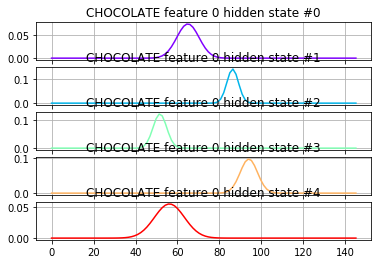

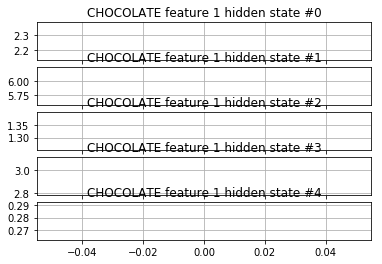

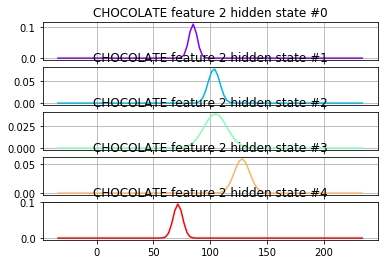

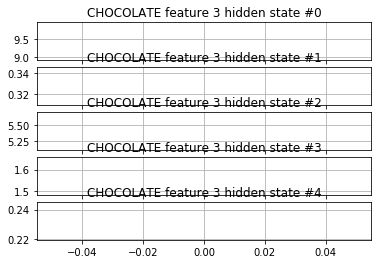

In [419]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [420]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [421]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'ALL' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold(n_splits=2)
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[1] Test fold indices:[0]
Train fold indices:[0] Test fold indices:[1]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [422]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [423]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [428]:
# TODO: Implement SelectorCV in my_model_selector.py
from my_model_selectors import SelectorCV

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 11 states with time 0.7274957220070064 seconds
Training complete for BOOK with 2 states with time 4.490472809993662 seconds
Training complete for VEGETABLE with 2 states with time 2.4080364509718493 seconds
Training complete for FUTURE with 2 states with time 4.588602346018888 seconds
Training complete for JOHN with 4 states with time 55.48024013102986 seconds


In [426]:
# TODO: Implement SelectorBIC in module my_model_selectors.py
from my_model_selectors import SelectorBIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 4 states with time 0.5837459140457213 seconds
Training complete for BOOK with 8 states with time 2.6767243369249627 seconds
Training complete for VEGETABLE with 7 states with time 1.0454263190040365 seconds
Training complete for FUTURE with 10 states with time 2.4614821029827 seconds
Training complete for JOHN with 14 states with time 32.58428074500989 seconds


In [429]:
# TODO: Implement SelectorDIC in module my_model_selectors.py
from my_model_selectors import SelectorDIC

training = asl.build_training(features_custom)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 9 states with time 3.5631558160530403 seconds
Training complete for BOOK with 15 states with time 5.244897583965212 seconds
Training complete for VEGETABLE with 14 states with time 4.448991141980514 seconds
Training complete for FUTURE with 15 states with time 5.576387476990931 seconds
Training complete for JOHN with 15 states with time 33.86652491707355 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**  In BIC, the number of free parameters increases as the number of states and features increase, leading to a higher (worse) BIC score, therefore penalizing model complexity; thus, BIC appears to favor simpler models. With DIC, unlike BIC, the goal is not to focus on the simplest model that can fit the data well; the goal with DIC is to consider competing classification categories (other words that the correct word could be) by penalizing the score if the log likelihood of the correct category (word) is too similar to the rest of the categories' (words') log likelihoods. In addition, because DIC depends on the log likelihood of other words, runtime might be slower than BIC's computations if the number of words increases. As for cross validation (CV), it takes longer in general to execute, especially as the number of folds increases. CV, however, seems to have more stability by returning a generally lower number of states compared to BIC and DIC.

<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [430]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 101.634s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for your experimentation and final submission cells.



In [199]:
from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [200]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [435]:
# Based on the `show_errors` function in `asl_utils.py`
def show_errors_summary(guesses, test_set):
    """ Print WER and total correct

    :param guesses: list of test item answers, ordered
    :param test_set: SinglesData object
    :return:
        nothing returned, prints error report

    WER = (S+I+D)/N  but we have no insertions or deletions for isolated words so WER = S/N
    """
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1

    print("\n**** WER = {}".format(float(S) / float(N)))
    print("Total correct: {} out of {}".format(N - S, N))

In [436]:
# TODO implement the recognize method in my_recognizer
from my_recognizer import recognize
from asl_utils import show_errors

In [437]:
def run_recognizer(features, model_selector):
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors_summary(guesses, test_set)

#### SelectorBIC Tests

In [305]:
run_recognizer(features_ground, SelectorBIC)


**** WER = 0.550561797752809
Total correct: 80 out of 178


In [306]:
run_recognizer(features_norm, SelectorBIC)


**** WER = 0.6123595505617978
Total correct: 69 out of 178


In [307]:
run_recognizer(features_polar, SelectorBIC)


**** WER = 0.5393258426966292
Total correct: 82 out of 178


In [308]:
run_recognizer(features_delta, SelectorBIC)


**** WER = 0.6235955056179775
Total correct: 67 out of 178


In [431]:
run_recognizer(features_custom, SelectorBIC)


**** WER = 0.5674157303370787
Total correct: 77 out of 178


#### SelectorDIC Tests

In [309]:
run_recognizer(features_ground, SelectorDIC)


**** WER = 0.5786516853932584
Total correct: 75 out of 178


In [310]:
run_recognizer(features_norm, SelectorDIC)


**** WER = 0.6235955056179775
Total correct: 67 out of 178


In [311]:
run_recognizer(features_polar, SelectorDIC)


**** WER = 0.5449438202247191
Total correct: 81 out of 178


In [312]:
run_recognizer(features_delta, SelectorDIC)


**** WER = 0.6573033707865169
Total correct: 61 out of 178


In [432]:
run_recognizer(features_custom, SelectorDIC)


**** WER = 0.5393258426966292
Total correct: 82 out of 178


#### SelectorCV Tests

In [329]:
run_recognizer(features_ground, SelectorCV)


**** WER = 0.5280898876404494
Total correct: 84 out of 178


In [330]:
run_recognizer(features_norm, SelectorCV)


**** WER = 0.601123595505618
Total correct: 71 out of 178


In [331]:
run_recognizer(features_polar, SelectorCV)


**** WER = 0.5730337078651685
Total correct: 76 out of 178


In [332]:
run_recognizer(features_delta, SelectorCV)


**** WER = 0.6179775280898876
Total correct: 68 out of 178


In [438]:
run_recognizer(features_custom, SelectorCV)


**** WER = 0.5786516853932584
Total correct: 75 out of 178


#### Top 3 Feature Sets and Model Selectors

In [439]:
def run_recognizer_details(features, model_selector):
    models = train_all_words(features, model_selector)
    test_set = asl.build_test(features)
    probabilities, guesses = recognize(models, test_set)
    show_errors(guesses, test_set)

In [440]:
# Best feature set and model selector #1
run_recognizer_details(features_ground, SelectorCV)


**** WER = 0.5280898876404494
Total correct: 84 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: JOHN *COAT *ARRIVE                                            JOHN WRITE HOMEWORK
   67: JOHN *MOTHER NOT BUY HOUSE                                    JOHN FUTURE NOT BUY HOUSE
    7: JOHN *GO1 *HAVE *WHAT                                         JOHN CAN GO CAN
  201: JOHN *SHOULD *GIVE *JOHN *ARRIVE HOUSE                        JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *BILL *MARY MARY                                          JOHN NOT VISIT MARY
  119: *PREFER *BUY1 IX CAR *SUE                                     SUE BUY IX CAR BLUE
   12: *IX CAN *CAN CAN                                              JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN *VIDEOTAPE YESTERDAY *TEACHER BOOK        

In [441]:
# Best feature set and model selector #2
run_recognizer_details(features_polar, SelectorBIC)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
  100: POSS NEW CAR BREAK-DOWN                                       POSS NEW CAR BREAK-DOWN
    2: *GO WRITE *NEW                                                JOHN WRITE HOMEWORK
   67: *SHOULD FUTURE *MARY BUY HOUSE                                JOHN FUTURE NOT BUY HOUSE
    7: JOHN *PEOPLE GO *ARRIVE                                       JOHN CAN GO CAN
  201: JOHN *MAN *MAN *LIKE BUY HOUSE                                JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *VISIT *GIVE MARY                                         JOHN NOT VISIT MARY
  119: *PREFER *BUY1 *CAR CAR *GO                                    SUE BUY IX CAR BLUE
   12: JOHN *WHAT *GO1 CAN                                           JOHN CAN GO CAN
   77: *JOHN BLAME *LOVE                                             ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

In [442]:
# Best feature set and model selector #3
run_recognizer_details(features_custom, SelectorDIC)


**** WER = 0.5393258426966292
Total correct: 82 out of 178
Video  Recognized                                                    Correct
  100: *IX NEW CAR BREAK-DOWN                                        POSS NEW CAR BREAK-DOWN
    2: JOHN *NEW *ARRIVE                                             JOHN WRITE HOMEWORK
   67: JOHN *IX *IX BUY HOUSE                                        JOHN FUTURE NOT BUY HOUSE
    7: JOHN *VISIT *ARRIVE *ARRIVE                                   JOHN CAN GO CAN
  201: JOHN *MARY MARY *MARY BUY HOUSE                               JOHN TELL MARY IX-1P BUY HOUSE
   74: *IX *MARY *GIVE MARY                                          JOHN NOT VISIT MARY
  119: *VISIT *BUY1 IX *JOHN *IX                                     SUE BUY IX CAR BLUE
   12: JOHN *WHAT *JOHN *HOUSE                                       JOHN CAN GO CAN
   77: *MARY BLAME MARY                                              ANN BLAME MARY
  142: JOHN BUY YESTERDAY WHAT BOOK                   

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**  From running all combinations of features and model selectors, the best feature sets were the ground and polar coordinates and custom features (normalized ground, normalized polar, and ground moving averages with a window of 5) because they had the lowest WERs, below 60%, regardless of the selectors chosen. This might be because all of them used ground coordinates as a basis, while the low-scoring features, norm and delta, used raw, non-ground x and y coordinates.

Out of the top 3, the "best" combination, or the combination that produced the lowest WER, was ground coordinate features with SelectorCV; one explanation for this is that, during my testing in Part 2, the cross validation selector with ground features tended to produce lower numbers of hidden states. From the lecture videos, it seems that it's always good to represent a word in as few states as possible, to "try the simple topology first and only add states when necessary" (Thad Starner, HMM Topologies video).

We can improve our WER by using n-grams, PCA, LDA, and better feature engineering. Here are some features to consider (assuming we were working with video image data as well): the dominant hand, hand and head tracking, hand velocity, and downscaled intensity of motion features.

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [443]:
from asl_test_recognizer import TestRecognize
suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 58.610s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [ ]:
# create a DataFrame of log likelihoods for the test word items
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()